**LSGAN PART-2**

In [1]:
# Import necessary libraries
import torch
import torchvision
import torch.nn as nn
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import PIL

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### **Step1. Load the Fashion MNIST dataset and replace the original dataset used in the demo.**

In [2]:
transform = Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))])
fashion_mnist = FashionMNIST(root='data', train=True, download=True, transform=transform)
batch_size = 100
data_loader = DataLoader(fashion_mnist, batch_size, shuffle=True)


100%|██████████| 26421880/26421880 [00:00<00:00, 124923512.62it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 3080011.01it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 59529608.46it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 14394851.33it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
# Accessing an image and its label
img, label = fashion_mnist[0]
print('Label: ', label)
print('Image shape:', img.shape)
print(img[:, 10:15, 10:15])  # Displaying a portion of the image
print('Minimum pixel value:', torch.min(img))
print('Maximum pixel value:', torch.max(img))

Label:  9
Image shape: torch.Size([1, 28, 28])
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])
Minimum pixel value: tensor(-1.)
Maximum pixel value: tensor(1.)


In [4]:
#denormalising the image as this will be useful to view the gerenrated images

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 9


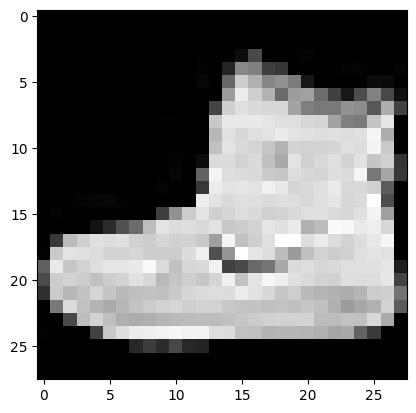

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

norm_img = denorm(img)
plt.imshow(norm_img[0], cmap='gray')
print('Label:', label)

Creating a dataloader to load the images in batches

In [6]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(fashion_mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([5, 1, 6, 9, 0, 2, 4, 6, 7, 1, 5, 2, 8, 3, 0, 1, 6, 1, 1, 4, 2, 4, 6, 2,
        6, 7, 1, 7, 2, 8, 4, 3, 7, 8, 1, 7, 8, 3, 2, 0, 7, 9, 5, 0, 8, 0, 6, 0,
        9, 2, 5, 1, 4, 6, 2, 7, 7, 4, 2, 3, 0, 9, 6, 0, 2, 1, 2, 2, 4, 2, 5, 8,
        0, 1, 4, 7, 0, 4, 9, 7, 0, 9, 7, 3, 5, 6, 3, 6, 6, 7, 9, 6, 5, 5, 1, 3,
        8, 8, 7, 3])


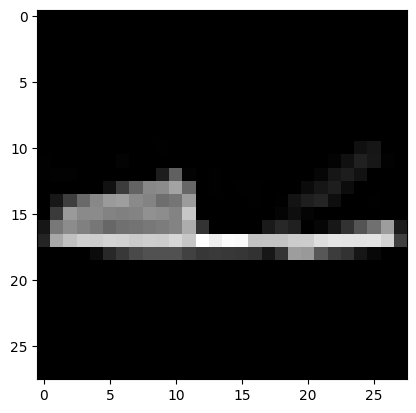

In [7]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

### **Step2. Train the LSGAN model to produce images in this new domain.**

**Discriminator Network**

In [8]:
import torch.nn as nn

latent_size = 64
hidden_size = 256
image_size = 28 * 28

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1)
).to(device)

**Generator Network**

In [9]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
).to(device)

In [10]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

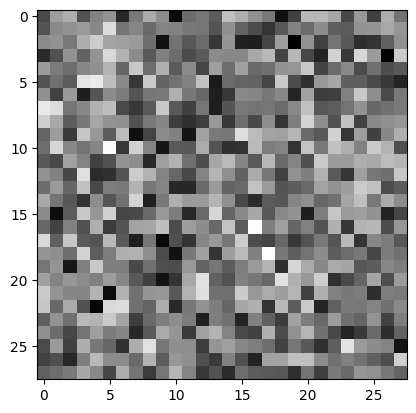

In [11]:
plt.imshow(gen_imgs[0], cmap='gray');

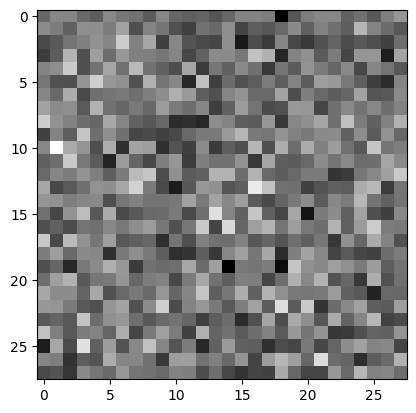

In [12]:
plt.imshow(gen_imgs[1], cmap='gray');

**Defining the loss functions and optimizers for both discriminator and generator**

**Using Mean Square Error Loss here, as LSGAN uses MSE as a loss function**

In [13]:
# Loss function
criterion = nn.MSELoss()

# Optimizers
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

**Discriminator Training**

In [14]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    real_labels = torch.ones(images.size(0), 1).to(device)
    fake_labels = torch.zeros(images.size(0), 1).to(device)

    outputs = D(images)
    d_loss_real = torch.mean((outputs - real_labels) ** 2)

    z = torch.randn(images.size(0), latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images.detach())
    d_loss_fake = torch.mean((outputs - fake_labels) ** 2)

    d_loss = d_loss_real + d_loss_fake
    reset_grad()
    d_loss.backward()
    d_optimizer.step()

    return d_loss

**Generator Training**

In [15]:
def train_generator():
    z = torch.randn(batch_size, latent_size).to(device)
    real_labels = torch.ones(batch_size, 1).to(device)

    fake_images = G(z)
    outputs = D(fake_images)
    g_loss = torch.mean((outputs - real_labels) ** 2)

    reset_grad()
    g_loss.backward()
    g_optimizer.step()

    return g_loss

Creating a directory - samples_lsgan where we can save intermediate outputs from the generator to visually inspect the progress of the model

In [16]:
sample_dir = 'samples_lsgan'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

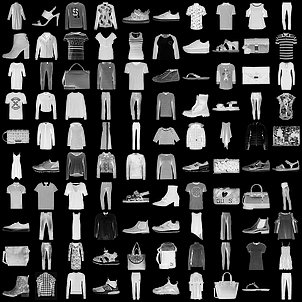

In [17]:
from IPython.display import Image
from torchvision.utils import save_image

for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

In [18]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def save_fake_images(index):
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

**Training the model initially with epochs of 100. Training the discriminator first and then generator**

In [19]:
num_epochs = 100
total_step = len(data_loader)
d_losses, g_losses = [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)

        d_loss = train_discriminator(images)
        g_loss = train_generator()

        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, total_step, d_loss.item(), g_loss.item()))

    save_fake_images(epoch+1)

Epoch [1/100], Step [200/600], d_loss: 0.0074, g_loss: 1.2365
Epoch [1/100], Step [400/600], d_loss: 0.0104, g_loss: 1.1913
Epoch [1/100], Step [600/600], d_loss: 0.0058, g_loss: 1.0910
Epoch [2/100], Step [200/600], d_loss: 0.0064, g_loss: 1.0984
Epoch [2/100], Step [400/600], d_loss: 0.0036, g_loss: 1.0757
Epoch [2/100], Step [600/600], d_loss: 0.0117, g_loss: 1.1059
Epoch [3/100], Step [200/600], d_loss: 0.0152, g_loss: 1.1632
Epoch [3/100], Step [400/600], d_loss: 0.0156, g_loss: 1.0858
Epoch [3/100], Step [600/600], d_loss: 0.0158, g_loss: 0.9834
Epoch [4/100], Step [200/600], d_loss: 0.0220, g_loss: 1.0318
Epoch [4/100], Step [400/600], d_loss: 0.0337, g_loss: 0.9581
Epoch [4/100], Step [600/600], d_loss: 0.0111, g_loss: 1.0585
Epoch [5/100], Step [200/600], d_loss: 0.0257, g_loss: 0.8557
Epoch [5/100], Step [400/600], d_loss: 0.0191, g_loss: 1.1752
Epoch [5/100], Step [600/600], d_loss: 0.0571, g_loss: 1.0111
Epoch [6/100], Step [200/600], d_loss: 0.0457, g_loss: 0.8824
Epoch [6

### **Step3. Attempt to save and display at least 3 samples produced from your GAN model. Describe and discuss any difficulties faced in this process.**

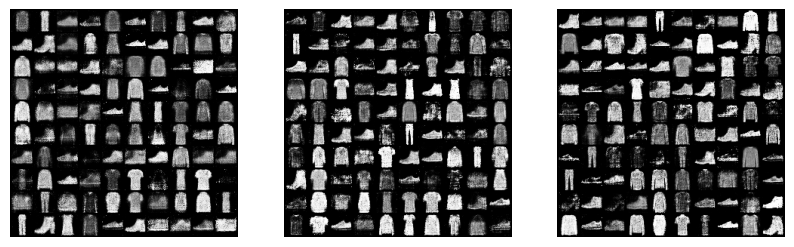

In [20]:
# Displaying the specified generated images
image_indices = [40, 77, 100]
num_images_to_display = len(image_indices)
fig, axs = plt.subplots(1, num_images_to_display, figsize=(10, 3))

for i, index in enumerate(image_indices):
    img_path = f'samples_lsgan/fake_images-{index:04d}.png'
    if os.path.exists(img_path):
        img = PIL.Image.open(img_path)
        axs[i].imshow(img)
        axs[i].axis('off')
    else:
        print(f"Image {index} not found.")

plt.show()

Difficulties faced in this process:

The variety of created samples, While LSGANs were meant to prevent mode collapse, there were times when the model produced quite similar results. It was tough to achieve a wide range of variations in the generated samples, and this affected the overall visual appeal and interest of the images.

Evaluating the quality of generated samples was changelling.Although visually seeing the samples provided some insight into the performance of the model, it was difficult to capture minor differences in sample quality and diversity. This subjective evaluation made it challenging to determine whether the model was accurately capturing the underlying data distribution and generating high-quality outputs.

Training process has taken quiet a time.

### **Step4. Save the model weights in the folder to be used later.**

In [21]:
torch.save(G.state_dict(), 'generator_lsgan.pth')
torch.save(D.state_dict(), 'discriminator_lsgan.pth')

### **Step5. Load the model using the saved weights.**

Loading the model by using the saved weights

In [22]:
#Defining Generator and Discriminator networks
latent_size = 64
hidden_size = 256
image_size = 784

# Loading the saved weights
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())
G.load_state_dict(torch.load('generator_lsgan.pth'))  #loaded with saved weights
G.eval()

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())
D.load_state_dict(torch.load('discriminator_lsgan.pth'))    #loaded with saved weights
D.eval()

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

### **Step 6: Re-train the LSGAN model to see if you can improve.**

### Compare it with GAN results

**Now re-training the LSGAN model with the saved weights from previous training and training this model with 100 epochs and saving the images to a new directory - retraining_samples_lsgan to view the images after training**

In [23]:
# Defining a new directory for saving images during re-training
retraining_sample_dir = 'retraining_samples_lsgan'
if not os.path.exists(retraining_sample_dir):
    os.makedirs(retraining_sample_dir)

def save_retraining_fake_images(index):
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = f'fake_images-{index:04d}.png'
    save_image(denorm(fake_images), os.path.join(retraining_sample_dir, fake_fname), nrow=10)

num_epochs = 100
sample_interval = 200

# starting the re-training the model
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)

        # Training the discriminator
        d_loss = train_discriminator(images)

        # Training the generator
        g_loss = train_generator()

        # Printing losses
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, len(data_loader), d_loss.item(), g_loss.item()))

        # Saving generated images at specified intervals
        if (i+1) % sample_interval == 0:
            save_retraining_fake_images(epoch * len(data_loader) + i + 1)


Epoch [1/100], Step [200/600], d_loss: 0.4499, g_loss: 0.1832
Epoch [1/100], Step [400/600], d_loss: 0.4419, g_loss: 0.1797
Epoch [1/100], Step [600/600], d_loss: 0.4457, g_loss: 0.1790
Epoch [2/100], Step [200/600], d_loss: 0.4418, g_loss: 0.1772
Epoch [2/100], Step [400/600], d_loss: 0.4247, g_loss: 0.1849
Epoch [2/100], Step [600/600], d_loss: 0.4468, g_loss: 0.1803
Epoch [3/100], Step [200/600], d_loss: 0.4388, g_loss: 0.1769
Epoch [3/100], Step [400/600], d_loss: 0.4394, g_loss: 0.1818
Epoch [3/100], Step [600/600], d_loss: 0.4506, g_loss: 0.1811
Epoch [4/100], Step [200/600], d_loss: 0.4370, g_loss: 0.1759
Epoch [4/100], Step [400/600], d_loss: 0.4307, g_loss: 0.1783
Epoch [4/100], Step [600/600], d_loss: 0.4340, g_loss: 0.1741
Epoch [5/100], Step [200/600], d_loss: 0.4472, g_loss: 0.1799
Epoch [5/100], Step [400/600], d_loss: 0.4512, g_loss: 0.1729
Epoch [5/100], Step [600/600], d_loss: 0.4449, g_loss: 0.1803
Epoch [6/100], Step [200/600], d_loss: 0.4448, g_loss: 0.1804
Epoch [6

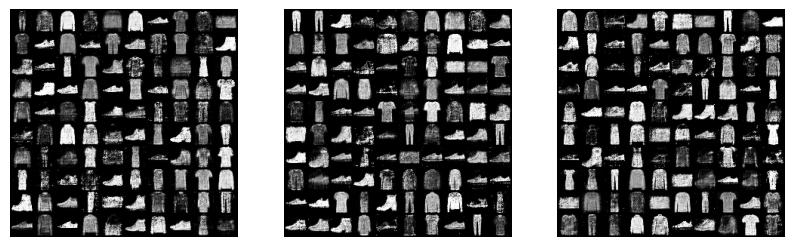

In [24]:
# Displaying the specified generated images after re-training
image_indices = [1000, 8000, 60000]
num_images_to_display = len(image_indices)
fig, axs = plt.subplots(1, num_images_to_display, figsize=(10, 3))

for i, index in enumerate(image_indices):
    img_path = f'retraining_samples_lsgan/fake_images-{index:04d}.png'
    if os.path.exists(img_path):
        img = PIL.Image.open(img_path)
        axs[i].imshow(img)
        axs[i].axis('off')
    else:
        print(f"Image {index} not found.")

plt.show()

**Save the model weights without using checkpoints**

Again saving the weights after re-training

In [25]:
# Save the generator and discriminator model weights after re-training
torch.save(G.state_dict(), 'generator_lsgan_retrained.pth')
torch.save(D.state_dict(), 'discriminator_lsgan_retrained.pth')

This will save the state dictionaries of both the generator and discriminator networks into files named 'generator_lsgan_retrained.pth' and 'discriminator_lsgan_retrained.pth', respectively

Loading the model by using the saved weights from retraining

In [26]:
#Defining Generator and Discriminator networks
latent_size = 64
hidden_size = 256
image_size = 784


# Loading the saved weights
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())
G.load_state_dict(torch.load('generator_lsgan_retrained.pth'))  #loaded with saved weights
G.eval()

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())
D.load_state_dict(torch.load('discriminator_lsgan_retrained.pth'))    #loaded with saved weights
D.eval()


Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

### Comparing it with GAN results

The GAN utilized Binary Cross Entropy (BCE) loss, while LS-GAN uses Mean Squared Error (MSE) loss, focusing on minimizing the squared difference between actual and predicted values.

Initially, the GAN was trained for 300 epochs, whereas LS-GAN achieved promising results after only 100 epochs, indicating faster convergence.

Both models exhibited a decrease in discriminator and generator loss over epochs. However, the GAN's discriminator loss showed fluctuations, suggesting challenges in distinguishing real from fake samples as training progressed. Whreas,LS-GAN demonstrated consistent decrease in discriminator loss, indicating improved discrimination ability, alongside decreasing generator loss, implying enhanced sample generation.
So, this consistent decrease in discriminator loss in LS-GAN implies that the model was able to learn more effectively from the data than GAN, potentially leading to better generalization to unseen samples.

LS-GAN showcased computational efficiency with its quicker convergence, benefiting from stability, faster training, and potentially a better sample quality within 100 epochs.

During re-training, both models underwent an additional 100 epochs. Despite observing decreasing loss in both cases, LS-GAN outperformed the GAN, yielding higher quality results.